# Load a thredds dataset
In the following example we will load a thredds dataset from the norwegian met.no thredds server.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pymepps

The first step is to load the dataset. This will be performed with pymepps.open_model_dataset. The NetCDF4 backend is also supporting opendap paths. So we could specify nc as data type.

In [2]:
metno_path = 'http://thredds.met.no/thredds/dodsC/meps25files/' \
    'meps_det_pp_2_5km_latest.nc'
metno_ds = pymepps.open_model_dataset(metno_path, 'nc')

100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


The resulting dataset is a SpatialDataset. The dataset has several methods to load a xr.DataArray from the path. It also possible to print the content of the dataset. The content contains the dataset type, the number of file handlers within the dataset and all available data variables.

In [3]:
print(metno_ds)

SpatialDataset
--------------
File handlers: 1
Variables: ['air_pressure_at_sea_level', 'air_temperature_2m', 'altitude', 'cloud_area_fraction', 'fog_area_fraction', 'forecast_reference_time', 'helicopter_triggered_index', 'high_type_cloud_area_fraction', 'land_area_fraction', 'low_type_cloud_area_fraction', 'medium_type_cloud_area_fraction', 'precipitation_amount', 'precipitation_amount_acc', 'precipitation_amount_high_estimate', 'precipitation_amount_low_estimate', 'precipitation_amount_middle_estimate', 'precipitation_amount_prob_low', 'projection_lambert', 'relative_humidity_2m', 'surface_air_pressure', 'thunderstorm_index_combined', 'wind_speed_maxarea_10m', 'wind_speed_of_gust', 'x_wind_10m', 'y_wind_10m']


The next step is to select/extract a variable from the Dataset. We will select the air temperature in 2 metre height and print the content of the resulting data

100%|██████████| 1/1 [00:21<00:00, 21.20s/it]


<xarray.DataArray 'air_temperature_2m' (runtime: 1, ensemble: 1, validtime: 67, height: 1, y: 929, x: 719)>
array([[[[[[ 291.478027, ...,  291.090332],
           ..., 
           [ 278.397949, ...,  282.883789]]],


         ..., 
         [[[ 291.09082 , ...,  290.721008],
           ..., 
           [ 278.949707, ...,  279.577637]]]]]])
Coordinates:
  * validtime  (validtime) datetime64[ns] 2017-07-19T06:00:00 ...
  * height     (height) float32 2.0
  * x          (x) float64 -8.974e+05 -8.949e+05 -8.924e+05 -8.899e+05 ...
  * y          (y) float64 -1.104e+06 -1.102e+06 -1.099e+06 -1.097e+06 ...
    longitude  (y, x) float64 1.918 1.954 1.989 2.025 2.06 2.096 2.131 2.167 ...
    latitude   (y, x) float64 52.3 52.31 52.31 52.32 52.32 52.32 52.33 52.33 ...
  * ensemble   (ensemble) int64 0
  * runtime    (runtime) object None
Attributes:
    long_name:                       Screen level temperature (T2M)
    standard_name:                   air_temperature
    units:                 

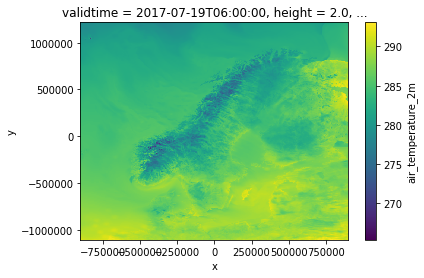

In [4]:
metno_t2m = metno_ds.select('air_temperature_2m')
print(metno_t2m)
metno_t2m.isel(validtime=0).plot()
plt.show()

We could see that the resulting data is a normal xarray.DataArray and all of the DataArray methods could be used. The coordinates of the DataArray are normalized. The DataArray is expanded with an accessor. Also the coordinates are normalized. We could access the accessor with metno_t2m.pp. The main methods of the accessor are allowing a grid handling. So our next step is to explore the grid of the DataArray.

In [5]:
print(metno_t2m.pp.grid)

ProjectionGrid
--------------
gridtype = projection
xlongname = x-coordinate in Cartesian system
xname = x
xunits = m
ylongname = y-coordinate in Cartesian system
yname = y
yunits = m
proj4 = +proj=lcc +lat_0=63 +lon_0=15 +lat_1=63 +lat_2=63 +no_defs +R=6.371e+06
gridsize = 667951.0
xsize = 719.0
ysize = 929.0
xdimname = x
ydimname = y
xfirst = -897442.2
xinc = 2500.0
yfirst = -1104322.0
yinc = 2500.0
grid_mapping = projection_lambert
grid_mapping_name = lambert_conformal_conic
standard_parallel = [63.0, 63.0]
longitude_of_central_meridian = 15.0
latitude_of_projection_origin = 63.0
earth_radius = 6371000.0


We could see that the grid is a grid with a defined projection. In our next step we will slice out an area around Hamburg. We will see that a new DataArray with a new grid is created.

In [6]:
hh_bounds = [9, 54, 11, 53]
t2m_hh = metno_t2m.pp.sellonlatbox(hh_bounds)
print(t2m_hh.pp.grid)
print(t2m_hh)

UnstructuredGrid
----------------
gridtype = unstructured
xlongname = longitude
xname = lon
xunits = degrees
ylongname = latitude
yname = lat
yunits = degrees
gridsize = 2401
<xarray.DataArray (runtime: 1, ensemble: 1, validtime: 67, height: 1, ncells: 2401)>
array([[[[[ 288.434265, ...,  287.86261 ]],

         ..., 
         [[ 289.025787, ...,  286.954559]]]]])
Coordinates:
  * runtime    (runtime) object None
  * ensemble   (ensemble) int64 0
  * validtime  (validtime) datetime64[ns] 2017-07-19T06:00:00 ...
  * height     (height) float32 2.0
  * ncells     (ncells) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
Attributes:
    long_name:                       Screen level temperature (T2M)
    standard_name:                   air_temperature
    units:                           K
    _ChunkSizes:                     [  1   1 929 719]
    Conventions:                     CF-1.6
    institution:                     Norwegian Meteorological Institute, MET ...
    creator_ur

We sliced a longitude and latitude box around the given grid. So we sliced the data in a longitude and latitude projection. Our original grid was in another projection with unstructured lat lon coordinates. So it is not possible to create a structured grid based on this slice. So the grid becomes an unstructured grid. In the next step we will show the remapping capabilities of the pymepps grid structure.

If we slice the data we have seen that the structured grid could not maintained. So in the next step we will create a structured LonLatGrid from scratch. After the grid building we will remap the raw DataArray basen on the new grid. 

The first step is to calculate the model resolution in degree.

In [7]:
res = 2500   # model resolution in metre
earth_radius = 6371000 # Earth radius in metre
res_deg = np.round(res*360/(earth_radius*2*np.pi), 4)
# rounded model resolution equivalent in degree if it where on the equator
print(res_deg)

0.0225


Our next step is to build the grid. The grid implementation is inspired by the climate data operators. So to build the grid we will use the same format.

In [8]:
grid_dict = dict(
    gridtype='lonlat',
    xsize=int((hh_bounds[2]-hh_bounds[0])/res_deg),
    ysize=int((hh_bounds[1]-hh_bounds[3])/res_deg),
    xfirst=hh_bounds[0],
    xinc=res_deg,
    yfirst=hh_bounds[3],
    yinc=res_deg,
)

Now we use our grid dict together with the GridBuilder to build our grid.

In [9]:
builder = pymepps.GridBuilder(grid_dict)
hh_grid = builder.build_grid()
print(hh_grid)

LonLatGrid
----------
gridtype = lonlat
xlongname = longitude
xname = lon
xunits = degrees
ylongname = latitude
yname = lat
yunits = degrees
xsize = 88
ysize = 44
xfirst = 9
xinc = 0.0225
yfirst = 53
yinc = 0.0225


Now we created the grid. The next step is a remapping of the raw DataArray to the new Grid. We will use th enearest neighbour approach to remap the data.

In [10]:
t2m_hh_remapped = metno_t2m.pp.remapnn(hh_grid)

In [11]:
print(t2m_hh_remapped)

<xarray.DataArray (runtime: 1, ensemble: 1, validtime: 67, height: 1, lat: 44, lon: 88)>
array([[[[[[ 288.265228, ...,  288.897858],
           ..., 
           [ 287.495361, ...,  289.750275]]],


         ..., 
         [[[ 287.590698, ...,  287.320648],
           ..., 
           [ 285.674713, ...,  290.341522]]]]]])
Coordinates:
  * runtime    (runtime) object None
  * ensemble   (ensemble) int64 0
  * validtime  (validtime) datetime64[ns] 2017-07-19T06:00:00 ...
  * height     (height) float32 2.0
  * lat        (lat) float64 53.0 53.02 53.05 53.07 53.09 53.11 53.14 53.16 ...
  * lon        (lon) float64 9.0 9.023 9.045 9.068 9.09 9.113 9.135 9.158 ...
Attributes:
    long_name:                       Screen level temperature (T2M)
    standard_name:                   air_temperature
    units:                           K
    _ChunkSizes:                     [  1   1 929 719]
    Conventions:                     CF-1.6
    institution:                     Norwegian Meteorological 

To plot the data in a map, we have to slice the data. We will select the first validtime as plotting parameter.

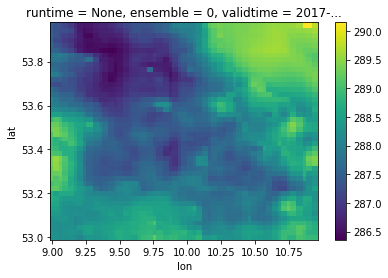

In [12]:
t2m_hh_remapped.isel(validtime=0).plot()
plt.show()

In the map around Hamburg we could see the north and baltic sea in the top edges. But with the nearest enighbour approach we retain some of the sharp edges at the map. Our last step is a second remap plot, this time with a bilinear approach.

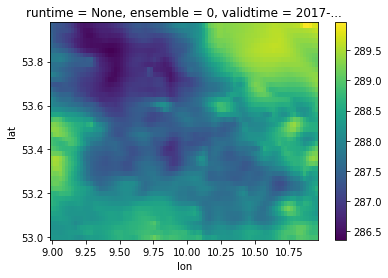

In [13]:
# sphinx_gallery_thumbnail_number = 3
metno_t2m.pp.remapbil(hh_grid).isel(validtime=0).plot()
plt.show()